### Welcome to a notebook to help download all the GCPC data (precip)

Push this button to open it in Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]( http://colab.research.google.com/github/dopplerchase/ATMS-597-SP-2020/blob/master/ATMS-597-SP-2020-Project-3/notebooks/GrabPrecip.ipynb)


### Install packages needed

In [77]:
!pip install wget
!pip install netCDF4

### import needed modules

In [0]:
from tqdm import tqdm
import xarray as xr
import numpy as np
import wget
import os 
from bs4 import BeautifulSoup
import re
import urllib.request
import pandas as pd

%pylab inline

### Define Class

In [0]:
class Rainy():
  """
  A Class to do some precip analysis. 
  """

  def __init__(self): 
    pass


  def getLinks(self,BASE_URL=None,TIME1=None,TIME2=None,verbose=True,begin_month = 6,end_month = 8):

    """
    This method uses webscraping (and Beautiful soup) to grab the links. 
    By default, it will create the links for 1996 to current. Also this defaults 
    to NH summer. To change to different months change begin_month and end_month 
    """

    if BASE_URL is None: 
      BASE_URL = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'

    if TIME1 is None:
      TIME1 = '1996-01-01'
    
    if TIME2 is None: 
      TIME2 = '2019-12-31'

    time_range=pd.date_range(start=TIME1,end=TIME2,freq='Y')
    links = []
    if verbose:
      for item in time_range.year:
          url=BASE_URL+str(item)
          print('year = ',item)
          print('Getting links from '+url)
          html_page = urllib.request.urlopen(url)
          soup = BeautifulSoup(html_page.read())
          #does not work for months > 10, but for this assignment its ok.
          for link in soup.findAll('a', attrs={'href': re.compile("^gpcp_v01r03_daily_d\d\d\d\d0(["+str(begin_month)+"-"+str(end_month)+"])")}):
                links.append(url+'/'+link.get('href'))
    else:
      for item in tqdm(time_range.year):
          url=BASE_URL+str(item)
          html_page = urllib.request.urlopen(url)
          soup = BeautifulSoup(html_page.read())
          for link in soup.findAll('a', attrs={'href': re.compile("^gpcp_v01r03_daily_d\d\d\d\d0(["+str(begin_month)+"-"+str(end_month)+"])")}):
              links.append(url+'/'+link.get('href'))

    self.links = links

  def download_links(self,parallel=True):

    """ Download all files to the current directory"""
    
    if os.path.isdir('./raw_data/') is False:
      os.mkdir('./raw_data/')

    if parallel:

      
      import multiprocessing as mp
      n_cpu = mp.cpu_count()
      pool = mp.Pool(processes=n_cpu)
      for _ in tqdm(pool.imap_unordered(download_par, self.links), total=len(self.links)):
          pass
      pool.close()
      pool.join()
    else:
      # Download all these files to this Google Drive folder
      for item in tqdm(self.links):
        ff=wget.download(item,'./raw_data/'+item[-40:])
    
  
  def get_loc(self,lon=None,lat=None,method='nearest'):
    if lon is None:
      lon = (360.-88.2434)
    if lat is None:
      lat = 40.1164
    data=xr.open_mfdataset('./raw_data/gp*.nc',combine='by_coords',concat_dim='time')
    data_champaign_jja=data.precip.sel(latitude=lat,longitude=lon,method=method)
    data_final=data_champaign_jja.to_series()   #Convert DataArray to Pandas Series for more flexibility 
    data_final[data_final==data_final.max()]=np.nan #Set unphysical values (O(1e36)) to NaNs 

    self.data = data_final

  def plot_cdf(self):

    import matplotlib 
    import matplotlib.pylab as plt

    matplotlib.rcParams.update({'font.size': 16.0})
    fig=plt.figure(figsize=(11,8))
    fig.set_facecolor('w')
    self.data.hist(cumulative=True, density=1,bins=500)
    perc95=self.data.quantile(q=0.95)
    plt.axvline(perc95,color='r')
    plt.title('CDF of JJA daily precip over Champaign, IL')
    plt.xlabel('Daily precipitation (mm)')
    plt.text(20.2,0.8,'95th percentile = '+str(perc95))


  def split_on_quantile(self,quantile=0.95):

    if os.path.isdir('./subset_data/') is False:
      os.mkdir('./subset_data/')
    percentile=self.data.quantile(q=quantile)
    dates_lt_percentile=pd.Series(self.data[self.data<percentile].index)   #Dates for data less than the percentile
    dates_gte_percentile=pd.Series(self.data[self.data>=percentile].index) #greater than or equal to the  percentile

    dates_gte_percentile.to_csv('./subset_data/precip_gte'+str(int(quantile*100))+'quant.csv')
    dates_lt_percentile.to_csv('./subset_data/precip_lt'+str(int(quantile*100))+'quant.csv')
    self.dates_gte_percentile = dates_gte_percentile
    self.dates_lt_percentile = dates_lt_percentile

def download_par(item):
  ff=wget.download(item,'./raw_data/'+item[-40:])
  return


### Initialize class and scrape links

In [79]:
drops = Rainy()
drops.getLinks(verbose=False)

100%|██████████| 24/24 [00:16<00:00,  1.45it/s]


### Download links

This can take a bit (5-10 mins). Go make a cup of tea

In [80]:
drops.download_links()

100%|██████████| 2117/2117 [04:53<00:00,  7.99it/s]


### Subset the global data to just your site of interest

In [0]:
drops.get_loc()

### Lets plot up the CDF

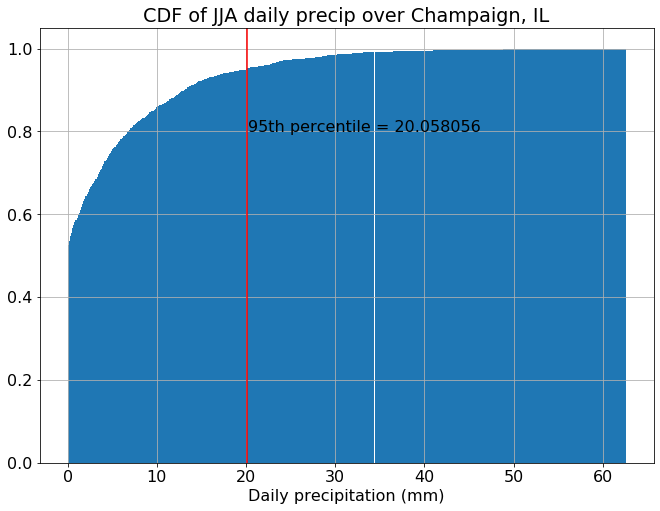

In [82]:
drops.plot_cdf()

### Split the data and save the data

In [83]:
drops.split_on_quantile()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:108: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:109: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
